## Check whether patches are fine

In [1]:
import os
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations as A


/home/users/amorgan/benchmark_CB_AM/venv/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of AlbumentationsX (2.0.10) is available! Your version is 2.0.9. Upgrade using: pip install -U albumentationsx
  check_for_updates()


In [2]:
import os
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter

def is_completely_black(image_path):
    """Check if an image is completely black (all pixels are 0) - optimized version"""
    try:
        img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)  # Read as grayscale for faster processing
        if img is None:
            return False, "Could not load image"
        
        # Fast check: if max value is 0, entire image is black
        return np.max(img) == 0, None
    except Exception as e:
        return False, f"Error: {str(e)}"

def is_block_color(image_path):
    """Check if an image has a single uniform color (block color) - optimized version"""
    try:
        img = cv2.imread(str(image_path))
        if img is None:
            return False, None, "Could not load image"
        
        # Fast check: compare first pixel with min/max of entire image
        first_pixel = img[0, 0]
        img_min = np.min(img, axis=(0, 1))
        img_max = np.max(img, axis=(0, 1))
        
        # If min equals max for all channels, it's a block color
        is_block = np.array_equal(img_min, img_max)
        
        # Return the uniform color if it's a block, otherwise the first pixel as representative
        dominant_color = img_min if is_block else first_pixel
        
        return is_block, dominant_color, None
    except Exception as e:
        return False, None, f"Error: {str(e)}"

def get_matching_files(images_dir, masks_dir):
    """Get pairs of matching image and mask files - optimized version"""
    # Use more specific patterns and avoid redundant operations
    image_files = set()
    mask_files = set()
    
    # Get all PNG files (most common format for patches)
    image_files.update(Path(images_dir).glob('*.png'))
    mask_files.update(Path(masks_dir).glob('*.png'))
    
    # If no PNG files, check other formats
    if not image_files:
        for ext in ['*.jpg', '*.jpeg', '*.bmp', '*.tiff', '*.tif']:
            image_files.update(Path(images_dir).glob(ext))
    
    if not mask_files:
        for ext in ['*.jpg', '*.jpeg', '*.bmp', '*.tiff', '*.tif']:
            mask_files.update(Path(masks_dir).glob(ext))
    
    # Create dictionaries with filename stems as keys
    image_dict = {f.stem: f for f in image_files}
    mask_dict = {f.stem: f for f in mask_files}
    
    # Find matching pairs using set intersection for efficiency
    common_stems = set(image_dict.keys()) & set(mask_dict.keys())
    matching_pairs = [(image_dict[stem], mask_dict[stem]) for stem in common_stems]
    
    return matching_pairs

def analyze_dataset(base_path, dataset_name):
    """Analyze a dataset (train or val) for black images and corresponding masks - optimized version"""
    
    images_dir = Path(base_path) / dataset_name / "images"
    masks_dir = Path(base_path) / dataset_name / "masks"
    
    if not images_dir.exists():
        print(f"Images directory not found: {images_dir}")
        return None
    
    if not masks_dir.exists():
        print(f"Masks directory not found: {masks_dir}")
        return None
    
    print(f"\nAnalyzing {dataset_name} dataset...")
    print(f"Images directory: {images_dir}")
    print(f"Masks directory: {masks_dir}")
    
    # Get matching image-mask pairs
    matching_pairs = get_matching_files(images_dir, masks_dir)
    
    if not matching_pairs:
        print(f"No matching image-mask pairs found in {dataset_name}")
        return None
    
    print(f"Found {len(matching_pairs)} matching image-mask pairs")
    
    # Analyze each pair
    results = {
        'total_pairs': len(matching_pairs),
        'black_images': 0,
        'black_images_with_block_masks': 0,
        'mask_colors_for_black_images': [],
        'all_mask_block_colors': [],
        'errors': []
    }
    
    # Process in batches for better memory management and progress reporting
    batch_size = 100
    for batch_start in range(0, len(matching_pairs), batch_size):
        batch_end = min(batch_start + batch_size, len(matching_pairs))
        batch_pairs = matching_pairs[batch_start:batch_end]
        
        for i, (img_path, mask_path) in enumerate(batch_pairs):
            # Check if image is completely black
            is_black, img_error = is_completely_black(img_path)
            
            if img_error:
                results['errors'].append(f"Image {img_path.name}: {img_error}")
                continue
            
            # Only check mask properties if we need them (for black images or general stats)
            mask_is_block, mask_color, mask_error = is_block_color(mask_path)
            
            if mask_error:
                results['errors'].append(f"Mask {mask_path.name}: {mask_error}")
                continue
            
            if is_black:
                results['black_images'] += 1
                results['mask_colors_for_black_images'].append(mask_color)
                
                if mask_is_block:
                    results['black_images_with_block_masks'] += 1
            
            # Collect all mask block colors for general statistics
            if mask_is_block:
                results['all_mask_block_colors'].append(tuple(mask_color))
        
        # Progress indicator
        print(f"  Processed {batch_end}/{len(matching_pairs)} pairs...")
    
    return results

def print_results(results, dataset_name):
    """Print analysis results"""
    if results is None:
        return
    
    print(f"\n{'='*50}")
    print(f"RESULTS FOR {dataset_name.upper()} DATASET")
    print(f"{'='*50}")
    
    total = results['total_pairs']
    black_count = results['black_images']
    black_with_block_masks = results['black_images_with_block_masks']
    
    print(f"Total image-mask pairs: {total}")
    print(f"Completely black images: {black_count}")
    print(f"Percentage of black images: {(black_count/total)*100:.2f}%")
    
    if black_count > 0:
        print(f"Black images with block-color masks: {black_with_block_masks}")
        print(f"Percentage of black images with block masks: {(black_with_block_masks/black_count)*100:.2f}%")
        
        # Show mask colors for black images
        if results['mask_colors_for_black_images']:
            print(f"\nMask colors for black images:")
            color_counts = Counter(tuple(color) for color in results['mask_colors_for_black_images'] if color is not None)
            for color, count in color_counts.most_common():
                print(f"  Color {color}: {count} occurrences")
    
    # Show general mask color statistics
    if results['all_mask_block_colors']:
        print(f"\nMost common block colors in all masks:")
        color_counts = Counter(results['all_mask_block_colors'])
        for color, count in color_counts.most_common(5):
            print(f"  Color {color}: {count} occurrences")
    
    if results['errors']:
        print(f"\nErrors encountered: {len(results['errors'])}")
        for error in results['errors'][:5]:  # Show first 5 errors
            print(f"  {error}")
        if len(results['errors']) > 5:
            print(f"  ... and {len(results['errors']) - 5} more errors")

def main():
    """Main function to analyze both train and validation datasets"""
    
    # Set the base path to your preprocessed_data directory
    base_path = "/gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/preprocessed_data"
    
    # Check if base directory exists
    if not Path(base_path).exists():
        print(f"Base directory '{base_path}' not found!")
        print("Please make sure the preprocessed_data directory exists in your current working directory.")
        return
    
    # Analyze train dataset
    train_results = analyze_dataset(base_path, "train")
    print_results(train_results, "train")
    
    # Analyze validation dataset
    val_results = analyze_dataset(base_path, "val")
    print_results(val_results, "val")
    
    # Summary comparison
    if train_results and val_results:
        print(f"\n{'='*50}")
        print("SUMMARY COMPARISON")
        print(f"{'='*50}")
        
        train_black_pct = (train_results['black_images'] / train_results['total_pairs']) * 100
        val_black_pct = (val_results['black_images'] / val_results['total_pairs']) * 100
        
        print(f"Train dataset: {train_black_pct:.2f}% black images")
        print(f"Validation dataset: {val_black_pct:.2f}% black images")

if __name__ == "__main__":
    main()


Analyzing train dataset...
Images directory: /gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/preprocessed_data/train/images
Masks directory: /gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/preprocessed_data/train/masks
Found 35664 matching image-mask pairs
  Processed 100/35664 pairs...
  Processed 200/35664 pairs...
  Processed 300/35664 pairs...
  Processed 400/35664 pairs...
  Processed 500/35664 pairs...
  Processed 600/35664 pairs...
  Processed 700/35664 pairs...
  Processed 800/35664 pairs...
  Processed 900/35664 pairs...
  Processed 1000/35664 pairs...
  Processed 1100/35664 pairs...
  Processed 1200/35664 pairs...
  Processed 1300/35664 pairs...
  Processed 1400/35664 pairs...
  Processed 1500/35664 pairs...
  Processed 1600/35664 pairs...
  Processed 1700/35664 pairs...
  Processed 1800/35664 pairs...
  Processed 1900/35664 pairs...
  Processed 2000/35664 pairs...
  Processed 2100/35664 pairs...
  Processed 2200/35664 pairs...
  Processed 2300/35664 pairs...
  Processed 2400/35

In [ ]:
# Run the optimized analysis
import time

start_time = time.time()
main()
end_time = time.time()

print(f"\nAnalysis completed in {end_time - start_time:.2f} seconds")

# Check whether dataloader works

Initializing IceDataset in train mode...
Found 35664 images and 35664 masks


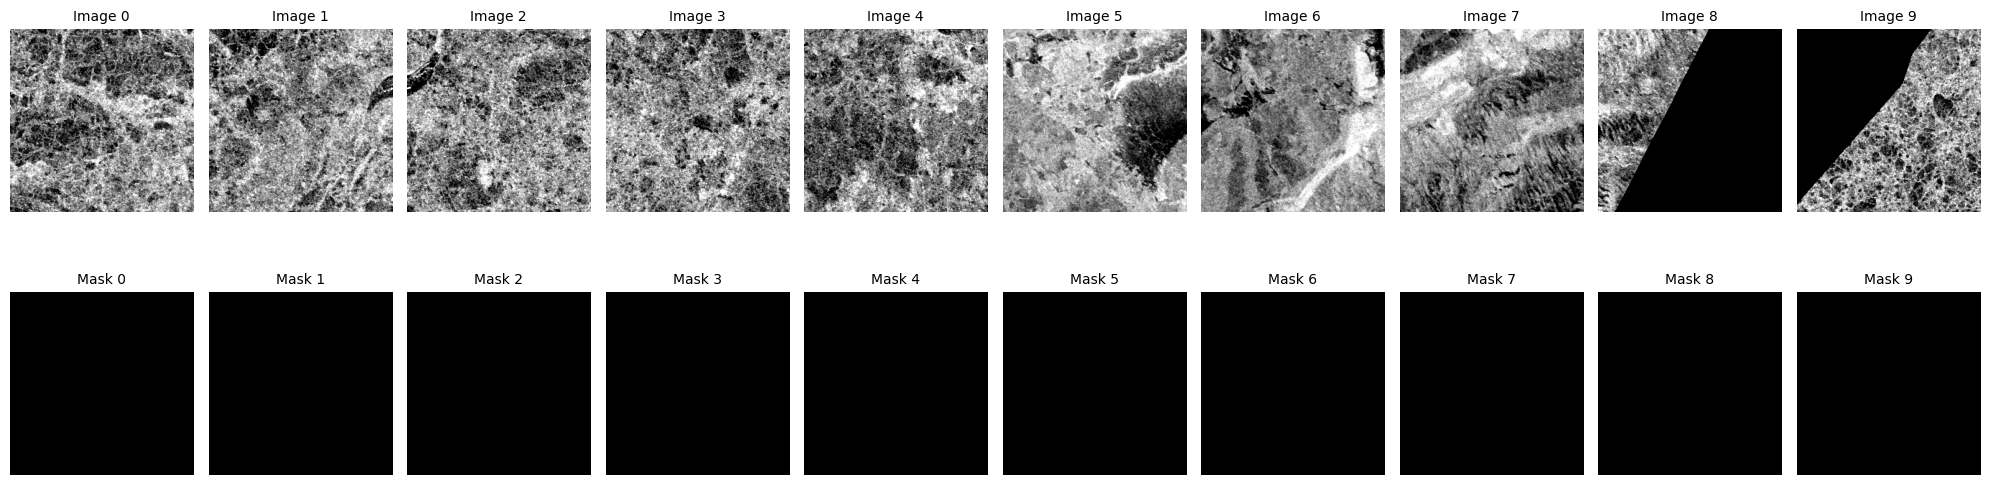

First sample - Image shape: torch.Size([1, 256, 256]), Mask shape: torch.Size([1, 256, 256])
Image min: -0.947, max: 2.160
Mask min: 255.000, max: 255.000
Image unique values: 256
Mask unique values: tensor([255.])


In [3]:
from data_processing.ice_data import IceDataset

# Create an instance of IceData
data_dir = "/gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/preprocessed_data"
dataset = IceDataset(mode='train', parent_dir=data_dir, augment=False)

# Plot 10 consecutive images and masks
n_samples = 10
fig, axes = plt.subplots(2, n_samples, figsize=(20, 6))

for i in range(n_samples):
    image, mask = dataset[i+1000]
    
    # Plot image in first row
    axes[0, i].imshow(image.squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Image {i}', fontsize=10)
    
    # Plot mask in second row
    axes[1, i].imshow(mask.squeeze(), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Mask {i}', fontsize=10)

plt.tight_layout()
plt.show()

# Print statistics for the first sample
image, mask = dataset[0]
print(f"First sample - Image shape: {image.shape}, Mask shape: {mask.shape}")
print(f"Image min: {image.min():.3f}, max: {image.max():.3f}")
print(f"Mask min: {mask.min():.3f}, max: {mask.max():.3f}")
print(f"Image unique values: {torch.unique(image).shape[0]}")
print(f"Mask unique values: {torch.unique(mask)}")


# Check whether mask works


Trying to read with rasterio...
Successfully read with rasterio: shape=(5109, 4127), dtype=uint8
Value range: 0 to 1


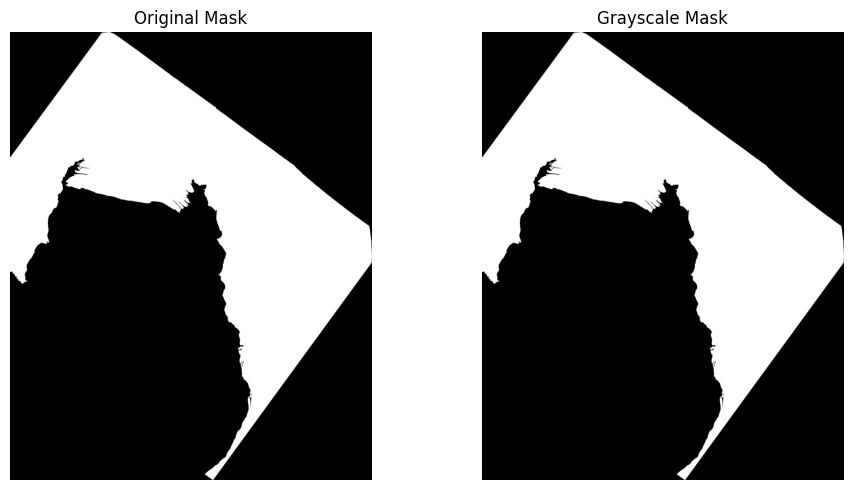

In [25]:
def _convert_mask_to_grayscale(mask):
    """
    Convert masks to grayscale format, preserving original values
    """
    if len(mask.shape) == 3 and mask.shape[2] >= 3:
        # Convert RGB to grayscale
        grey_mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    elif len(mask.shape) == 2:
        # Already grayscale
        grey_mask = mask
    else:
        print(f"Warning: Unexpected mask shape: {mask.shape}")
        return mask
    
    # Ensure it's in 0-255 range for PNG saving
    if grey_mask.max() > 255:
        grey_mask = ((grey_mask - grey_mask.min()) / (grey_mask.max() - grey_mask.min()) * 255).astype(np.uint8)
    
    return grey_mask

# Test it
if os.path.exists(mask_path):
    print(f"\nTrying to read with rasterio...")
    try:
        with rasterio.open(mask_path) as src:
            mask = src.read(1)  # Read first band
            print(f"Successfully read with rasterio: shape={mask.shape}, dtype={mask.dtype}")
            print(f"Value range: {mask.min()} to {mask.max()}")
            
            # Convert to grayscale only
            grayscale_mask = _convert_mask_to_grayscale(mask)
            
            # Display the masks
            plt.figure(figsize=(10, 5))
            
            plt.subplot(1, 2, 1)
            plt.title('Original Mask')
            plt.imshow(mask, cmap='gray')
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.title('Grayscale Mask')
            plt.imshow(grayscale_mask, cmap='gray')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
    except Exception as e:
        print(f"Error with rasterio: {e}")

# Check file pairs

In [27]:
def _get_file_pairs(satellite_dir):
    """
    Get paired image and mask files for preprocessed data structure
    
    returns a list of (image_path, mask_path) tuples
    """
    # Fix the directory structure to match your preprocessed data
    images_dir = satellite_dir / 'images'  # Changed from 'scenes'
    masks_dir = satellite_dir / 'masks'
    
    if not images_dir.exists() or not masks_dir.exists():
        print(f"Images or masks directory does not exist for {satellite_dir}")
        print(f"  Images dir exists: {images_dir.exists()}")
        print(f"  Masks dir exists: {masks_dir.exists()}")
        return []
    
    # Look for PNG files first (common for preprocessed patches)
    image_files = list(images_dir.glob('*.png'))
    mask_files = list(masks_dir.glob('*.png'))
    
    # If no PNG files, try other formats
    if not image_files:
        for ext in ['*.tif', '*.jpg', '*.jpeg']:
            image_files.extend(images_dir.glob(ext))
    
    if not mask_files:
        for ext in ['*.tif', '*.jpg', '*.jpeg']:
            mask_files.extend(masks_dir.glob(ext))
    
    print(f"Found {len(image_files)} image files and {len(mask_files)} mask files")
    
    file_pairs = []
    unmatched_images = []
    unmatched_masks = []
    
    # Create a set of mask stems for quick lookup
    mask_stems = {mask_file.stem for mask_file in mask_files}
    
    for img_path in image_files:
        if img_path.stem in mask_stems:
            mask_path = masks_dir / f"{img_path.stem}.{mask_files[0].suffix[1:]}"
            file_pairs.append((img_path, mask_path))
        else:
            unmatched_images.append(img_path.name)
    
    # Find unmatched masks
    image_stems = {img_file.stem for img_file in image_files}
    for mask_file in mask_files:
        if mask_file.stem not in image_stems:
            unmatched_masks.append(mask_file.name)
    
    # Log unmatched files
    if unmatched_images:
        print(f"WARNING: {len(unmatched_images)} unmatched image files:")
        for img_name in unmatched_images[:5]:  # Show first 5
            print(f"  - {img_name}")
        if len(unmatched_images) > 5:
            print(f"  ... and {len(unmatched_images) - 5} more")
    
    if unmatched_masks:
        print(f"WARNING: {len(unmatched_masks)} unmatched mask files:")
        for mask_name in unmatched_masks[:5]:  # Show first 5
            print(f"  - {mask_name}")
        if len(unmatched_masks) > 5:
            print(f"  ... and {len(unmatched_masks) - 5} more")
    
    return file_pairs

# Test the function
satellite_dir = Path("/gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/preprocessed_data/train")
file_pairs = _get_file_pairs(satellite_dir)
if file_pairs:
    print(f"Found {len(file_pairs)} matching image-mask pairs")
    for img_path, mask_path in file_pairs[:5]:  # Show first 5 pairs
        print(f"Image: {img_path.name}, Mask: {mask_path.name}")
else:
    print("No matching image-mask pairs found.")

Found 38951 image files and 38950 mask files
  - S1A_20171119_HH_EW_GRDM_1SDH_6E90__77_44_990_8960_2560.png
Found 38950 matching image-mask pairs
Image: ENV_20060205_VV_1PNESA20060205__11_225_102_1536_0.png, Mask: ENV_20060205_VV_1PNESA20060205__11_225_102_1536_0.png
Image: ENV_20060205_VV_1PNESA20060205__11_225_103_1536_256.png, Mask: ENV_20060205_VV_1PNESA20060205__11_225_103_1536_256.png
Image: ENV_20060205_VV_1PNESA20060205__11_225_104_1536_512.png, Mask: ENV_20060205_VV_1PNESA20060205__11_225_104_1536_512.png
Image: ENV_20060205_VV_1PNESA20060205__11_225_105_1536_768.png, Mask: ENV_20060205_VV_1PNESA20060205__11_225_105_1536_768.png
Image: ENV_20060205_VV_1PNESA20060205__11_225_106_1536_1024.png, Mask: ENV_20060205_VV_1PNESA20060205__11_225_106_1536_1024.png


# Print raw images and masks side by side with their shapes


PROCESSING ERS
Found 32 image files and 32 mask files in ERS
Found 32 matching pairs


Pair 1:
  Image: ERS_19911203_VV_RIS_1PNESA19911203.tif
    Shape: (4270, 4292), Dtype: float32, Range: 0.00 to 7.57
  Mask: ERS_19911203_VV_RIS_1PNESA19911203.tif
    Shape: (4270, 4292), Dtype: uint8, Range: 0.00 to 1.00

Pair 2:
  Image: ERS_19911205_VV_WIS_1PNESA19911205.tif
    Shape: (4703, 4841), Dtype: float32, Range: 0.00 to 4.43
  Mask: ERS_19911205_VV_WIS_1PNESA19911205.tif
    Shape: (4703, 4841), Dtype: uint8, Range: 0.00 to 1.00

Pair 3:
  Image: ERS_19911207_VV_FIS_1PNESA19911207.tif
    Shape: (4214, 4478), Dtype: float32, Range: 0.00 to 4.27
  Mask: ERS_19911207_VV_FIS_1PNESA19911207.tif
    Shape: (4214, 4478), Dtype: uint8, Range: 0.00 to 1.00

Pair 4:
  Image: ERS_19920814_VV_RG_1PNESA19920814.tif
    Shape: (3361, 4479), Dtype: float32, Range: 0.00 to 36.87
  Mask: ERS_19920814_VV_RG_1PNESA19920814.tif
    Shape: (3361, 4479), Dtype: uint8, Range: 0.00 to 1.00

Pair 5:
  Image: ERS_19940306_VV_LDIS_1PNESA19940306.tif
    Shape: (3503, 4591), Dtype: float32, Range: 

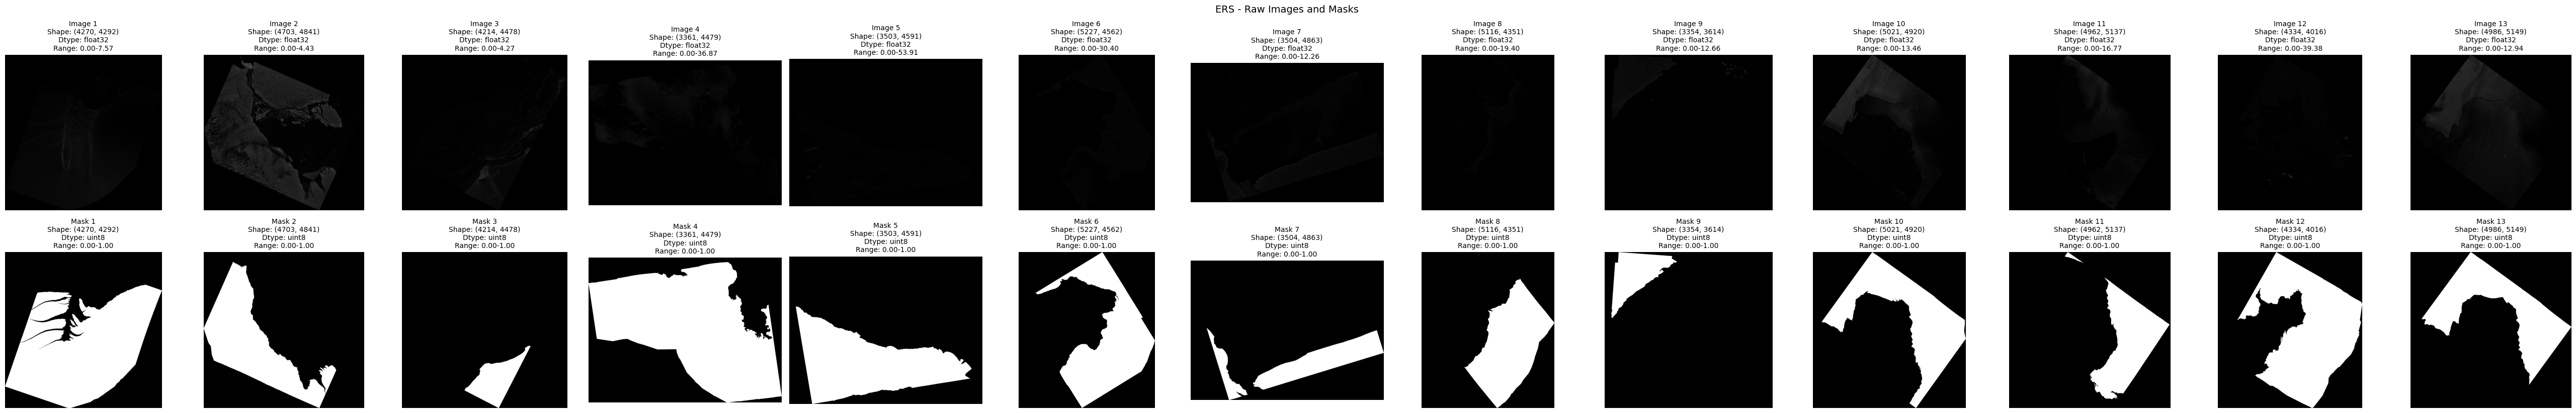


PROCESSING ENVISAT
Found 4 image files and 4 mask files in Envisat
Found 4 matching pairs
Pair 1:
  Image: ENV_20060205_VV_1PNESA20060205.tif
    Shape: (5109, 4127), Dtype: float32, Range: nan to nan
  Mask: ENV_20060205_VV_1PNESA20060205.tif
    Shape: (5109, 4127), Dtype: uint8, Range: 0.00 to 1.00

Pair 2:
  Image: ENV_20070528_VV_1PNESA20070528.tif
    Shape: (5124, 4721), Dtype: float32, Range: nan to nan
  Mask: ENV_20070528_VV_1PNESA20070528.tif
    Shape: (5124, 4721), Dtype: uint8, Range: 0.00 to 1.00

Pair 3:
  Image: ENV_20090623_VV_1PNESA20090623.tif
    Shape: (4666, 3563), Dtype: float32, Range: nan to nan
  Mask: ENV_20090623_VV_1PNESA20090623.tif
    Shape: (4666, 3563), Dtype: uint8, Range: 0.00 to 1.00

Pair 4:
  Image: ENV_20100301_VV_1PNESA20100301.tif
    Shape: (4630, 2479), Dtype: float32, Range: nan to nan
  Mask: ENV_20100301_VV_1PNESA20100301.tif
    Shape: (4630, 2479), Dtype: uint8, Range: 0.00 to 1.00



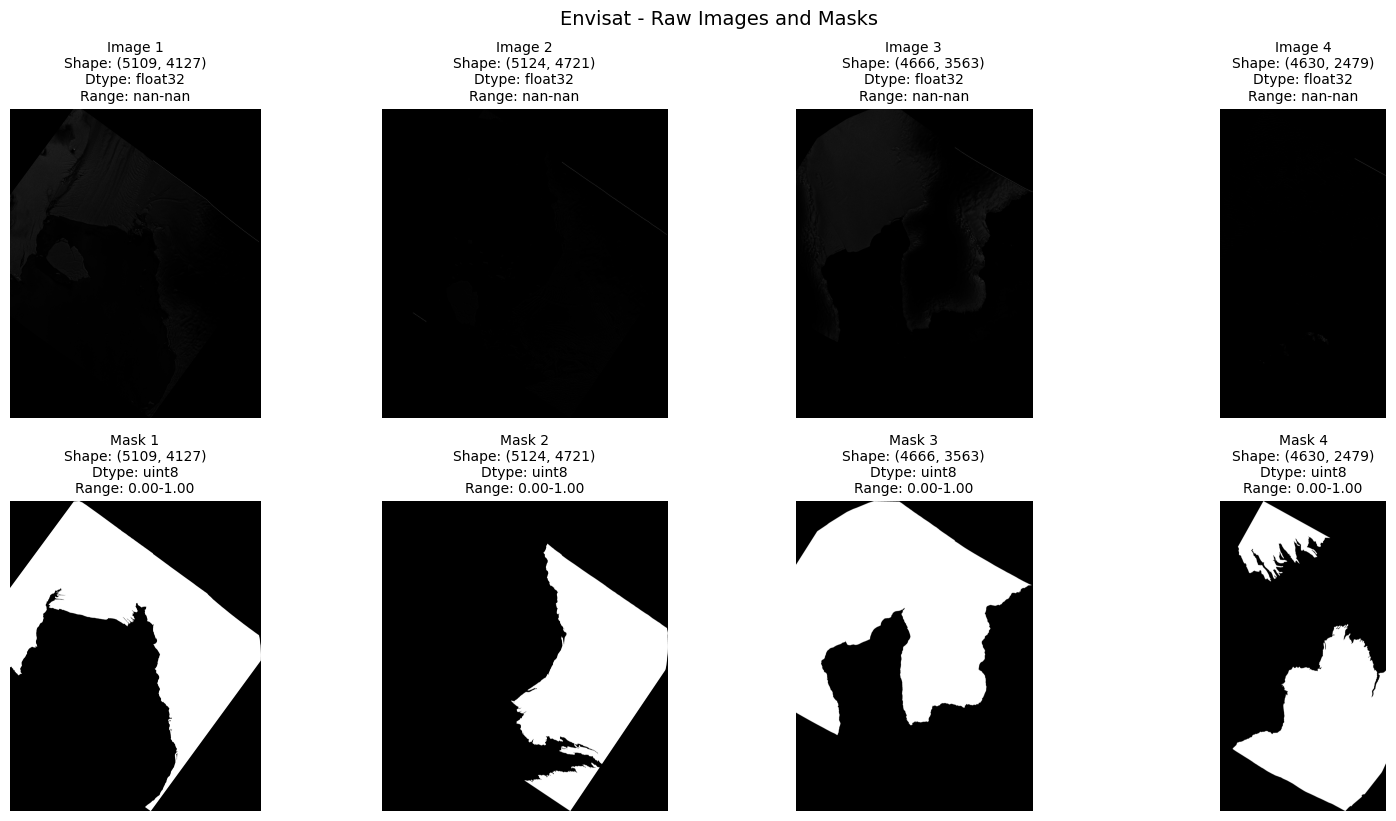

In [5]:
# Print raw images and masks side by side with their shapes
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def plot_raw_image_mask_pairs(base_path, satellite_name, n_samples=5):
    """
    Plot raw images and masks side by side with their shapes
    
    Args:
        base_path: Path to benchmark_data_CB directory
        satellite_name: Name of satellite folder (e.g., 'Sentinel-1', 'ERS', 'Envisat')
        n_samples: Number of samples to display
    """
    satellite_dir = Path(base_path) / satellite_name
    scenes_dir = satellite_dir / 'scenes'
    masks_dir = satellite_dir / 'masks'
    
    if not scenes_dir.exists() or not masks_dir.exists():
        print(f"Scenes or masks directory does not exist for {satellite_name}")
        print(f"  Scenes dir exists: {scenes_dir.exists()}")
        print(f"  Masks dir exists: {masks_dir.exists()}")
        return
    
    # Get matching image-mask pairs
    image_files = list(scenes_dir.glob('*.tif'))
    mask_files = list(masks_dir.glob('*.tif'))
    
    print(f"Found {len(image_files)} image files and {len(mask_files)} mask files in {satellite_name}")
    
    # Create a dictionary for quick lookup
    mask_dict = {mask_file.stem: mask_file for mask_file in mask_files}
    
    # Find matching pairs
    matching_pairs = []
    for img_file in image_files:
        if img_file.stem in mask_dict:
            matching_pairs.append((img_file, mask_dict[img_file.stem]))
    
    print(f"Found {len(matching_pairs)} matching pairs")
    
    if not matching_pairs:
        print("No matching pairs found!")
        return
    
    # Plot the first n_samples pairs
    n_to_plot = min(n_samples+10, len(matching_pairs))
    
    fig, axes = plt.subplots(2, n_to_plot, figsize=(4*n_to_plot, 8))
    if n_to_plot == 1:
        axes = axes.reshape(2, 1)
    
    for i in range(n_to_plot):
        img_path, mask_path = matching_pairs[i]
        
        try:
            # Read image
            with rasterio.open(img_path) as src:
                image = src.read(1)  # Read first band
                img_shape = image.shape
                img_dtype = image.dtype
                img_min, img_max = image.min(), image.max()
            
            # Read mask
            with rasterio.open(mask_path) as src:
                mask = src.read(1)  # Read first band
                mask_shape = mask.shape
                mask_dtype = mask.dtype
                mask_min, mask_max = mask.min(), mask.max()
            
            # Plot image
            axes[0, i].imshow(image, cmap='gray')
            axes[0, i].set_title(f'Image {i+1}\nShape: {img_shape}\nDtype: {img_dtype}\nRange: {img_min:.2f}-{img_max:.2f}', 
                                fontsize=10)
            axes[0, i].axis('off')
            
            # Plot mask
            axes[1, i].imshow(mask, cmap='gray')
            axes[1, i].set_title(f'Mask {i+1}\nShape: {mask_shape}\nDtype: {mask_dtype}\nRange: {mask_min:.2f}-{mask_max:.2f}', 
                                fontsize=10)
            axes[1, i].axis('off')
            
            print(f"Pair {i+1}:")
            print(f"  Image: {img_path.name}")
            print(f"    Shape: {img_shape}, Dtype: {img_dtype}, Range: {img_min:.2f} to {img_max:.2f}")
            print(f"  Mask: {mask_path.name}")
            print(f"    Shape: {mask_shape}, Dtype: {mask_dtype}, Range: {mask_min:.2f} to {mask_max:.2f}")
            print()
            
        except Exception as e:
            print(f"Error processing pair {i+1}: {e}")
            # Show error in plot
            axes[0, i].text(0.5, 0.5, f'Error loading\n{img_path.name}', 
                           ha='center', va='center', transform=axes[0, i].transAxes)
            axes[1, i].text(0.5, 0.5, f'Error loading\n{mask_path.name}', 
                           ha='center', va='center', transform=axes[1, i].transAxes)
            axes[0, i].set_title(f'Image {i+1} - ERROR', fontsize=10)
            axes[1, i].set_title(f'Mask {i+1} - ERROR', fontsize=10)
    
    plt.tight_layout()
    plt.suptitle(f'{satellite_name} - Raw Images and Masks', fontsize=14, y=1.02)
    plt.show()

# Set the base path
base_path = "/gws/nopw/j04/iecdt/amorgan/benchmark_data_CB"

# Plot samples from each satellite
satellites = ['ERS', 'Envisat']

for satellite in satellites:
    print(f"\n{'='*60}")
    print(f"PROCESSING {satellite.upper()}")
    print(f"{'='*60}")
    plot_raw_image_mask_pairs(base_path, satellite, n_samples=3)

In [8]:
# Quick test script
import rasterio
import numpy as np

# Test the problematic masks
mask_paths = [
    "/gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/preprocessed_data/val/masks/S1A_20180921_HH_EW_GRDM_1SDH_8801__132_216_684_4096_7168.png",  # The black one
    "/gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/preprocessed_data/val/masks/ERS_20021103_VV_PIG_1PNESA20021103__168_0_230_2816_2560.png",  # The working one
]

for path in mask_paths:
    with rasterio.open(path) as src:
        mask = src.read()
        print(f"\n{path}:")
        print(f"Shape: {mask.shape}, dtype: {mask.dtype}")
        print(f"Value range: {mask.min()} to {mask.max()}")
        print(f"Unique values: {np.unique(mask)}")
        if len(mask.shape) == 3:
            for i in range(mask.shape[0]):
                print(f"  Band {i}: {mask[i].min()} to {mask[i].max()}")


/gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/preprocessed_data/val/masks/S1A_20180921_HH_EW_GRDM_1SDH_8801__132_216_684_4096_7168.png:
Shape: (1, 256, 256), dtype: uint8
Value range: 0 to 1
Unique values: [0 1]
  Band 0: 0 to 1

/gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/preprocessed_data/val/masks/ERS_20021103_VV_PIG_1PNESA20021103__168_0_230_2816_2560.png:
Shape: (1, 256, 256), dtype: uint8
Value range: 0 to 0
Unique values: [0]
  Band 0: 0 to 0


/home/users/amorgan/benchmark_CB_AM/venv/lib/python3.10/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [4]:
# Enhanced plotting code to check mask properties
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def analyze_raw_masks(base_path, satellite_name, n_samples=3):
    """
    Analyze raw masks to understand their format and properties
    """
    satellite_dir = Path(base_path) / satellite_name
    scenes_dir = satellite_dir / 'scenes'
    masks_dir = satellite_dir / 'masks'
    
    if not scenes_dir.exists() or not masks_dir.exists():
        print(f"Scenes or masks directory does not exist for {satellite_name}")
        return
    
    # Get matching image-mask pairs
    image_files = list(scenes_dir.glob('*.tif'))
    mask_files = list(masks_dir.glob('*.tif'))
    
    # Create a dictionary for quick lookup
    mask_dict = {mask_file.stem: mask_file for mask_file in mask_files}
    
    # Find matching pairs
    matching_pairs = []
    for img_file in image_files:
        if img_file.stem in mask_dict:
            matching_pairs.append((img_file, mask_dict[img_file.stem]))
    
    print(f"\n{'='*60}")
    print(f"ANALYZING {satellite_name.upper()} MASKS")
    print(f"{'='*60}")
    
    for i in range(min(n_samples, len(matching_pairs))):
        img_path, mask_path = matching_pairs[i]
        
        print(f"\nSample {i+1}: {mask_path.name}")
        print("-" * 40)
        
        try:
            # Read mask with rasterio to get all bands
            with rasterio.open(mask_path) as src:
                print(f"  Number of bands: {src.count}")
                print(f"  Data type: {src.dtypes[0]}")
                print(f"  Dimensions: {src.width} x {src.height}")
                
                if src.count == 1:
                    # Single band (likely grayscale)
                    mask = src.read(1)
                    print(f"  Single band mask shape: {mask.shape}")
                    print(f"  Value range: {mask.min()} to {mask.max()}")
                    print(f"  Unique values: {np.unique(mask)}")
                    print(f"  Is grayscale: YES")
                else:
                    # Multi-band (likely RGB)
                    mask_all_bands = src.read()  # Read all bands
                    print(f"  Multi-band mask shape: {mask_all_bands.shape}")
                    print(f"  Is grayscale: NO (RGB/Multi-channel)")
                    
                    # Check if all bands are identical (pseudo-RGB)
                    if src.count >= 3:
                        band1 = mask_all_bands[0]
                        band2 = mask_all_bands[1] 
                        band3 = mask_all_bands[2]
                        
                        if np.array_equal(band1, band2) and np.array_equal(band1, band3):
                            print(f"  All RGB bands are identical - pseudo-grayscale")
                        else:
                            print(f"  RGB bands differ")
                            
                        print(f"  Band 1 range: {band1.min()} to {band1.max()}")
                        print(f"  Band 1 unique values: {np.unique(band1)}")
                        
        except Exception as e:
            print(f"  Error reading mask: {e}")

# Run the analysis
base_path = "/gws/nopw/j04/iecdt/amorgan/benchmark_data_CB"
satellites = ['ERS', 'Envisat']

for satellite in satellites:
    analyze_raw_masks(base_path, satellite, n_samples=3)


ANALYZING ERS MASKS

Sample 1: ERS_19911203_VV_RIS_1PNESA19911203.tif
----------------------------------------
  Number of bands: 1
  Data type: uint8
  Dimensions: 4292 x 4270


/home/users/amorgan/benchmark_CB_AM/venv/lib/python3.10/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


  Single band mask shape: (4270, 4292)
  Value range: 0 to 1
  Unique values: [0 1]
  Is grayscale: YES

Sample 2: ERS_19911205_VV_WIS_1PNESA19911205.tif
----------------------------------------
  Number of bands: 1
  Data type: uint8
  Dimensions: 4841 x 4703
  Single band mask shape: (4703, 4841)
  Value range: 0 to 1
  Unique values: [0 1]
  Is grayscale: YES

Sample 3: ERS_19911207_VV_FIS_1PNESA19911207.tif
----------------------------------------
  Number of bands: 1
  Data type: uint8
  Dimensions: 4478 x 4214
  Single band mask shape: (4214, 4478)
  Value range: 0 to 1
  Unique values: [0 1]
  Is grayscale: YES

ANALYZING ENVISAT MASKS

Sample 1: ENV_20060205_VV_1PNESA20060205.tif
----------------------------------------
  Number of bands: 1
  Data type: uint8
  Dimensions: 4127 x 5109
  Single band mask shape: (5109, 4127)
  Value range: 0 to 1
  Unique values: [0 1]
  Is grayscale: YES

Sample 2: ENV_20070528_VV_1PNESA20070528.tif
----------------------------------------
  Num

# Code to generate a nice background image

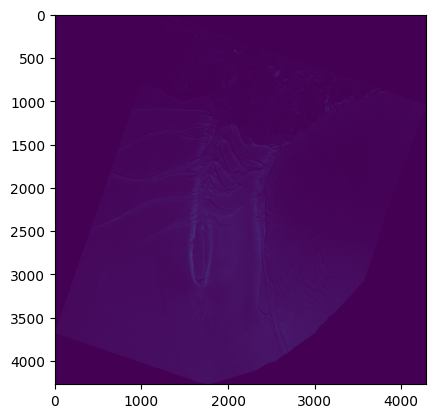

In [4]:
image_path ="/gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/ERS/scenes/ERS_19911203_VV_RIS_1PNESA19911203.tif"

import rasterio
from matplotlib import pyplot

src = rasterio.open(image_path)
pyplot.imshow(src.read(1))
pyplot.show()